In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.optimizers as optim

# ---------------------------
# 1. Data Loading & Cleaning
# ---------------------------
df = pd.read_csv('Chainlink_cleaned.csv')

# Process Timestamp column if it exists
if 'Timestamp' in df.columns:
    # Extract date portion (YYYY-MM-DD) using regex and convert to datetime
    df['Timestamp'] = pd.to_datetime(
        df['Timestamp'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0],
        format='%Y-%m-%d'
    )
    df.sort_values('Timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Remove duplicate rows
df = df.drop_duplicates()

# Convert the 'Close' column to numeric and fill missing values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Close'] = df['Close'].fillna(method='ffill')

# If Timestamp exists, set it as index
if 'Timestamp' in df.columns:
    df.set_index('Timestamp', inplace=True)

# ---------------------------
# 2. Data Preparation for Deep Learning
# ---------------------------
# Use the 'Close' column as our time series data
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Helper function to create overlapping sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training (80%) and test (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ---------------------------
# 3. Define Model Architectures
# ---------------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=optim.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=optim.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(128))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=optim.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
models = {
    'LSTM': build_lstm_model(input_shape),
    'CNN-LSTM': build_cnn_lstm_model(input_shape),
    'GRU': build_gru_model(input_shape)
}

# ---------------------------
# 4. Train Models & Evaluate on Test Set
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              callbacks=[early_stop], verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)
    r2 = r2_score(y_test_actual, y_pred)
    results[name] = r2
    print(f"{name} Test R2 Score: {r2:.4f}")

# Select best performing model
best_model_name = max(results, key=results.get)
print("\nBest Model:", best_model_name, "with Test R2 Score:", results[best_model_name])
best_model = models[best_model_name]


Training LSTM model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
LSTM Test R2 Score: 0.3971

Training CNN-LSTM model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
CNN-LSTM Test R2 Score: 0.6991

Training GRU model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
GRU Test R2 Score: 0.8692

Best Model: GRU with Test R2 Score: 0.869226097874447


In [32]:
# ---------------------------
# Tuning the GRU Model
# ---------------------------
def build_tuned_gru_model(input_shape):
    model = Sequential()
    # First GRU layer with 256 units (increased capacity) and return sequences for stacking
    model.add(GRU(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.4))  # Increased dropout for better regularization
    # Second GRU layer with 256 units
    model.add(GRU(256))
    model.add(Dropout(0.4))
    # Output layer for regression
    model.add(Dense(1))

    # Use a lower learning rate for finer optimization
    optimizer = optim.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the tuned GRU model using the same input shape
tuned_gru_model = build_tuned_gru_model(input_shape)
tuned_gru_model.summary()

# Define early stopping to prevent overfitting
early_stop_tuned = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the tuned GRU model with more epochs (up to 300) to allow for convergence
history_tuned = tuned_gru_model.fit(X_train, y_train,
                                    epochs=300,
                                    batch_size=64,
                                    validation_split=0.2,
                                    callbacks=[early_stop_tuned],
                                    verbose=1)

# ---------------------------
# Evaluate the Tuned GRU Model on the Test Set
# ---------------------------
# Predict on the test set and invert the scaling
y_pred_tuned_scaled = tuned_gru_model.predict(X_test)
y_pred_tuned = scaler.inverse_transform(y_pred_tuned_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Compute the R² score on the test set for the tuned model
tuned_r2 = r2_score(y_test_actual, y_pred_tuned)
print("Tuned GRU Test R2 Score: {:.4f}".format(tuned_r2))


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 60, 256)             │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,921 (2.27 MB)

 Trainable params: 593,921 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.6308 - val_loss: 0.0845
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 974ms/step - loss: 0.4504 - val_loss: 0.0920
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - loss: 0.3611 - val_loss: 0.0691
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - loss: 0.3994 - val_loss: 0.0541
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - loss: 0.3353 - val_loss: 0.0633
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - loss: 0.3375 - val_loss: 0.0646
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - loss: 0.3953 - val_loss: 0.0541
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - loss: 0.3146 - val_loss: 0.0576
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 701ms/step - loss: 0.3342 - val_loss: 0.0504
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - loss: 0.3299 - val_loss: 0.0483
Epoch 11/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - loss: 0.3453 - val_loss: 0.0525
Epoch 12/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 740ms/step - loss: 0.288

In [34]:
import pickle
from tensorflow.keras.models import model_from_json

# ---------------------------
# Save the Tuned GRU Model as a Pickle File
# ---------------------------
# Get the model architecture as JSON and the weights as a list of arrays
model_data = {
    "architecture": tuned_gru_model.to_json(),
    "weights": tuned_gru_model.get_weights()
}

# Save the dictionary containing the architecture and weights to a pickle file
with open("tuned_gru_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model saved as tuned_gru_model.pkl")

Model saved as tuned_gru_model.pkl


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━

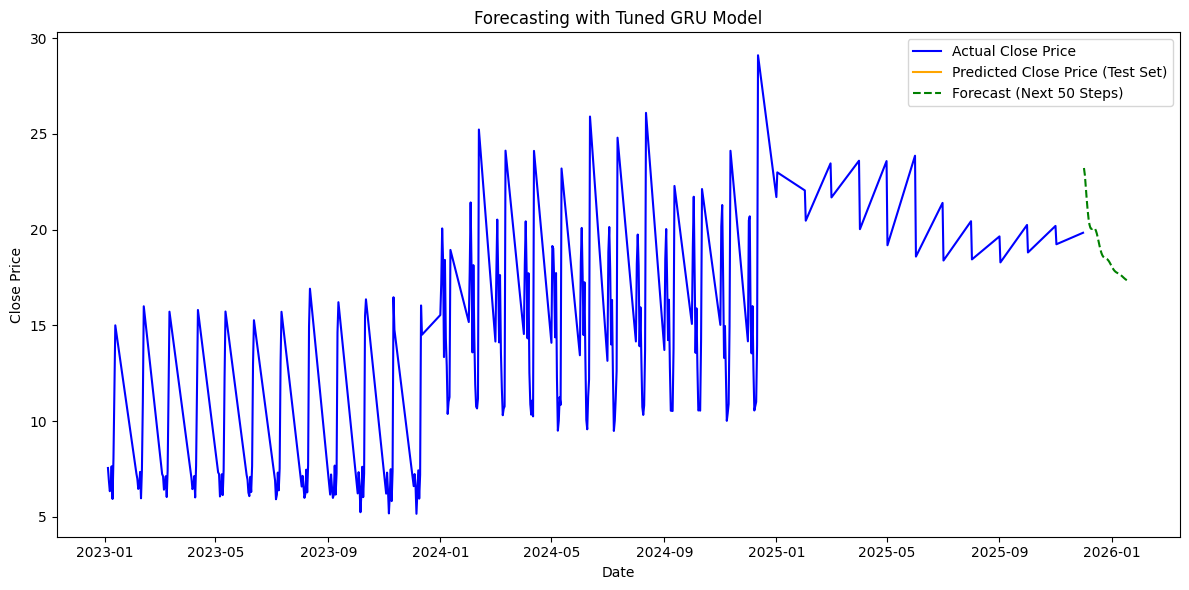

In [37]:
# ---------------------------
# 6. Forecast Future 50 Steps Using Recursive Prediction
# ---------------------------
forecast_steps = 50
forecast_scaled = []
# Use the last available sequence from the entire scaled data as the seed
last_sequence = scaled_data[-seq_length:].copy()

for _ in range(forecast_steps):
    current_seq = last_sequence.reshape(1, seq_length, 1)
    next_val_scaled = tuned_gru_model.predict(current_seq)
    forecast_scaled.append(next_val_scaled[0, 0])
    # Slide the window: remove the oldest value and add the new prediction
    last_sequence = np.append(last_sequence[1:], [[next_val_scaled[0, 0]]], axis=0)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# ---------------------------
# 7. Visualization of Forecast
# ---------------------------
plt.figure(figsize=(12, 6))

# Plot actual Close prices in blue
if df.index.inferred_type == 'datetime64':
    dates = df.index
    plt.plot(dates, data, label='Actual Close Price', color='blue')

    # (Optional) Plot test predictions in orange
    test_start = train_size + seq_length
    test_end = test_start + len(y_test)
    test_dates = df.index[test_start:test_end]
    plt.plot(test_dates, y_pred_tuned, label='Predicted Close Price (Test Set)', color='orange')

    # Ensure forecast starts strictly after the last date in the dataset
    last_date = df.index.max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    xlabel = 'Date'
else:
    dates = np.arange(len(data))
    plt.plot(dates, data, label='Actual Close Price', color='blue')

    test_start = train_size + seq_length
    test_end = test_start + len(y_test)
    test_indices = np.arange(test_start, test_end)
    plt.plot(test_indices, y_pred_tuned, label='Predicted Close Price (Test Set)', color='orange')

    last_idx = len(data) - 1
    forecast_dates = np.arange(last_idx + 1, last_idx + 1 + forecast_steps)
    xlabel = 'Time Step'

# Plot forecast in green dashed line, strictly after the actual data ends
plt.plot(forecast_dates, forecast, label='Forecast (Next 50 Steps)', linestyle='--', color='green')
plt.xlabel(xlabel)
plt.ylabel('Close Price')
plt.title('Forecasting with Tuned GRU Model')
plt.legend()
plt.tight_layout()
plt.show()